# Analyzing Association in Babylonian Zodiacal Medical Ingredients

M. Willis Monroe

The use of the zodiac in diverse forms of scribal knowledge in the Late Babylonian period
allowed scholars to approach and organize traditional texts in new ways. From calendrical to medical
material, the zodiacal schemes could be applied to a range of text genres. The coupling of zodiacal
signs and medical ingredients, for example, offered an opportunity to link celestial signs and earthly
objects. This paper will investigate the connections between the signs of the zodiac and medical
ingredients in Late Babylonian texts.

The principal corpus from which to draw out these connections is the Micro-zodiac tables from
Uruk and Babylon, which contain a wide range of information connected to a complicated scheme of
zodiacal sign pairs. Unlike other rows on the table which have prior textual traditions with which to
compare logical structure, the medical ingredients and their connection to the zodiacal signs must be
analyzed in their local context by bringing in comparisons with other contemporary texts which use
both signs of the zodiac and medical ingredients. Some of these contemporary texts are closely related
to the Micro-zodiac in structures, while others represent disparate traditions but still make use of
zodiacal signs and medical ingredients.

This study makes use of modern text processing techniques to compute the relative distance
between the groupings of medical ingredients in an effort to understand the logic behind their
association with certain zodiacal signs. The zodiacal scheme, as mentioned above, is complex and the
connection between sign and ingredient is not straight forward. This study will analyze texts across
genre and provenance in order to elucidate whether the pattern of association was based on the type or
origin of the text.

The first part of this notebook involves importing the relevant libraries (Pandas, Seaborn, and parts of SciKit-learn and NLTK).  Then a few configurations are changed, surpressing warnings, and setting the font for the graphs.

In [1]:
# Initial setup and importing of useful libraries:
# Inline graphs
%matplotlib inline

import csv
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import average, dendrogram

# Supress warnings
import warnings
warnings.filterwarnings('ignore')

# Set the font for graphs
sns.set(font='Brill', font_scale=1.75)

The next four functions are all helper functions written in order to assist in processing the data.  They're relatively specific to the data I'm working with but can either be adapted to other forms of data, or serve as a rough guideline for how to process other formats.  The first three functions should be called in order to produce an adjacency matrix and output it to CSV in order to graph it with Gephi.  The final function is just a utility for looking for possibles user entered errors in the data, it doesn't work particularly well but is a useful quick check.

In [2]:
def make_bags(in_df, index='ID', content='name only'):
    """
    Convert DataFrame into bag-of-words model
    
    This function takes an input DataFrame consisting of multiple rows and columns
    and groups all items under the column `content` that share the same value in
    the column `index`.
    
    Paramters
    ---------
    in_df : DataFrame
        The input DataFrame
    index : str
        The name of the column to serve as the index for the result
    content : str
        The name of the column to group under each item in the `index`
    
    Returns
    -------
    DataFrame
        A DataFrame where each unique item from the `index` column of the input
        DataFrame is given a row with all of the items from the `content` column
        which shared its value.
    """
    bags_of_ingredients = []
    for cell in in_df[index].unique():
        bag = ','.join(in_df[in_df[index] == cell][content])
        bags_of_ingredients.append((cell, bag))

    return pd.DataFrame(bags_of_ingredients)

In [3]:
def make_dtm(in_df, normalize=True):
    """
    Convert bag-of-words model to document term matrix
    
    This function takes a bag-of-words model DataFrame as its input and outputs
    either a DTM as an array, or if `as_df` is set True a DataFrame of the DTM
    with appropriate labels and headings.
    
    Paramters
    ---------
    in_df : DataFrame
        A bag-of-words model DataFrame, preferably from the make_bags() function
    normalize : bool
        normalize multiple occurences of a term to just 
     
    Returns
    -------
    array
        A DTM array
    DataFrame
        A DTM as a DataFrame
    """
    vec = CountVectorizer(analyzer='word', token_pattern=r'[^,]+')
    dtm = vec.fit_transform(in_df[1])
    if normalize:
        dtm[dtm > 1] = 1
    df_dtm = pd.DataFrame(
        dtm.toarray(), columns=vec.get_feature_names(), index=in_df[0])
    return df_dtm

In [4]:
def make_adjacency_matrix(dtm, similarity=True):
    """
    Convert a DTM to an adjacency matrix
    
    Takes a DTM and converts it to an adjacency matrix using cosine distance,
    also fills the diagonal of the matrix with zeros to remove self-loops.
    
    If `similarity` is True, it returns the inverse for use in Gephi.
    
    Paramaters
    ---------
    dtm : array
        A document term matrix, preferably from the make_dtm() function
    similarity : bool
        If True, the result is inverted to represent the cosine similarity.
       
    Returns
    -------
    DataFrame
        A labeled matrix
    """
    matrix = squareform(pdist(dtm.as_matrix(), metric='cosine'))
    if similarity:
        matrix = abs(matrix - 1)
    np.fill_diagonal(matrix, 0)
    matrix = matrix.tolist()

    df_matrix = pd.DataFrame(
        matrix, columns=dtm.index.tolist(), index=dtm.index.tolist())
    return df_matrix

In [5]:
def write_csv(df_matrix, filename, number_labels=False):
    """
    Output adjacency matrix as a csv file
    
    Takes an adjacency matrix and outputs it to a csv file using to_csv() with
    some fixes to make it easier to import into Gephi.  Also will replace labels
    with numbers, and write out secondary label csv
    
    Parameters
    ----------
    df_matrix : DataFrame
        Adjacency matrix DataFrame created by make_adjacency_matrix()
    filename : str
        Filename for csv file
    number_labels : bool
        Whether or not the function should replace all labels with an index number and
        write out secondary label list csv file.
    """
    if number_labels:
        with open(filename[:-4] + '-labels.csv', 'w') as f:
            writer = csv.writer(f, delimiter=';')
            writer.writerow(['Id', 'Label'])
            for line in zip(range(len(df_matrix.index)), df_matrix.index):
                writer.writerow(line)
            df_matrix.columns = range(len(df_matrix.columns))
    
    df_matrix.insert(0, ' ', df_matrix.columns)
    df_matrix.to_csv(filename, sep=';', index=False)

This next cell contains the main processing with Pandas to get the data from a CSV file I created into a number of useful Pandas DataFrame for further analysis.  It starts by importing the raw DataFrame and then filling all missing values with '0'.  Next it filters to get rid of any rows where the 'name only' field is 0, because those rows are not useful for this analysis.  Then two new columns are added by combining existing columns, these are purely for convenience and make later processing easier.  Finally, I go through the data looking for any rows where the 'name only' field consists of only x's '.'s or spaces, as those would give many false positives.  In the end I convert this cleaned DataFrame into two, one for just the Micro-zodiac and one for the Micro-zodiac and the Calendar texts.

In [6]:
# Start by importing a manually coded csv of the texts
ingredients = pd.read_csv("Zodiac Ingredients - Sheet1.csv")
ingredients.fillna(value="0", inplace=True)
# Get rid of the rows with 0 in the name field
ingredients = ingredients[ingredients['name only'] != '0']
# Create a new column (ID) with the format "#Text / Majorsign-minorsign"
ingredients['ID'] = '#' + ingredients['text'].map(
    str) + "/" + ingredients['zodiacal location']
# Create a new column (name_and_type) which combines the 'name only' field and its type.
ingredients[
    'name_and_type'] = ingredients['name only'] + ' (' + ingredients['type'] + ")"
# Get rid of any rows where 'name only' is only made up up x's or '.'s
cleaned_ingredients = ingredients[ingredients['name only'].str.match(
    '^[x .]+$') == False]
mz_ingredients = cleaned_ingredients[cleaned_ingredients['text_type'] ==
                                     'Micro-zodiac']
ct_ingredients = cleaned_ingredients[cleaned_ingredients['text_type'] ==
                                     'Calendar-text']

This cell shows how to use the helper functions defined above to take two different DataFrames run them through the analysis and write out the CSV files for use by Gephi.

In [7]:
# Write out adjacency for different groupings of ingredients
# Cell as index
datasets = [('MZ', mz_ingredients), ('MZ_and_CT', cleaned_ingredients)]
for dataset in datasets:
    name = dataset[0]
    df = dataset[1]
    df_bags = make_bags(df)
    df_dtm = make_dtm(df_bags)
    df_matrix = make_adjacency_matrix(df_dtm)
    write_csv(df_matrix, name)
    
# Ingredient as index
ingredient_bags = make_bags(cleaned_ingredients, index='name only', content='ID')
ingredient_dtm = make_dtm(ingredient_bags)
ingredient_matrix = make_adjacency_matrix(ingredient_dtm)
write_csv(ingredient_matrix, 'Ingredients.csv', number_labels=True)

# Ingredients with type as index
ingredient_type_bags = make_bags(cleaned_ingredients, index='name_and_type', content='ID')
ingredient_type_dtm = make_dtm(ingredient_type_bags)
ingredient_type_matrix = make_adjacency_matrix(ingredient_type_dtm)
write_csv(ingredient_type_matrix, 'Ingredients and Type.csv', number_labels=True)

# Graphing

At this point, with the CSVs created, we can now import them into Gephi for analysis.  Because they're adjacency matrices the only way to import them successfully into Gephi is to start with nothing open and use File->Open and then mark it as an "Undirected graph" some instructions can be found here: https://eight2late.wordpress.com/2015/12/02/a-gentle-introduction-to-network-graphs-using-r-and-gephi/

We can also use the DataFrames created above to do simple graphing with Seaborn which you see below.

In [30]:
# Plot a simple count of ingredients which occure more than 4 times
# Fix with ingredient_type_bags, easier access to data

mats_over_4 = cleaned_ingredients.groupby('name_and_type').filter(
    lambda x: len(x) > 4)['name_and_type']
#mats_over_4 = mats_over_4[~mats_over_4.isin(['x (0)'])]

plt.figure(figsize=(24, 12), dpi=600)
ax = sns.countplot(x=mats_over_4)
ax.set(
    xlabel='Ingredient',
    title="Common Ingredients in the Micro-zodiac and Calendar texts")
plt.savefig('Ingredient Counts.png', format='png', dpi=600)

# Appendix
This section is a further exploration of the data using hierarchical clustering with the results visualized with a dendrogram.

In [10]:
# Frequency of cosine distances greater than 0
df_bags = make_bags(cleaned_ingredients)
dtm = make_dtm(df_bags)

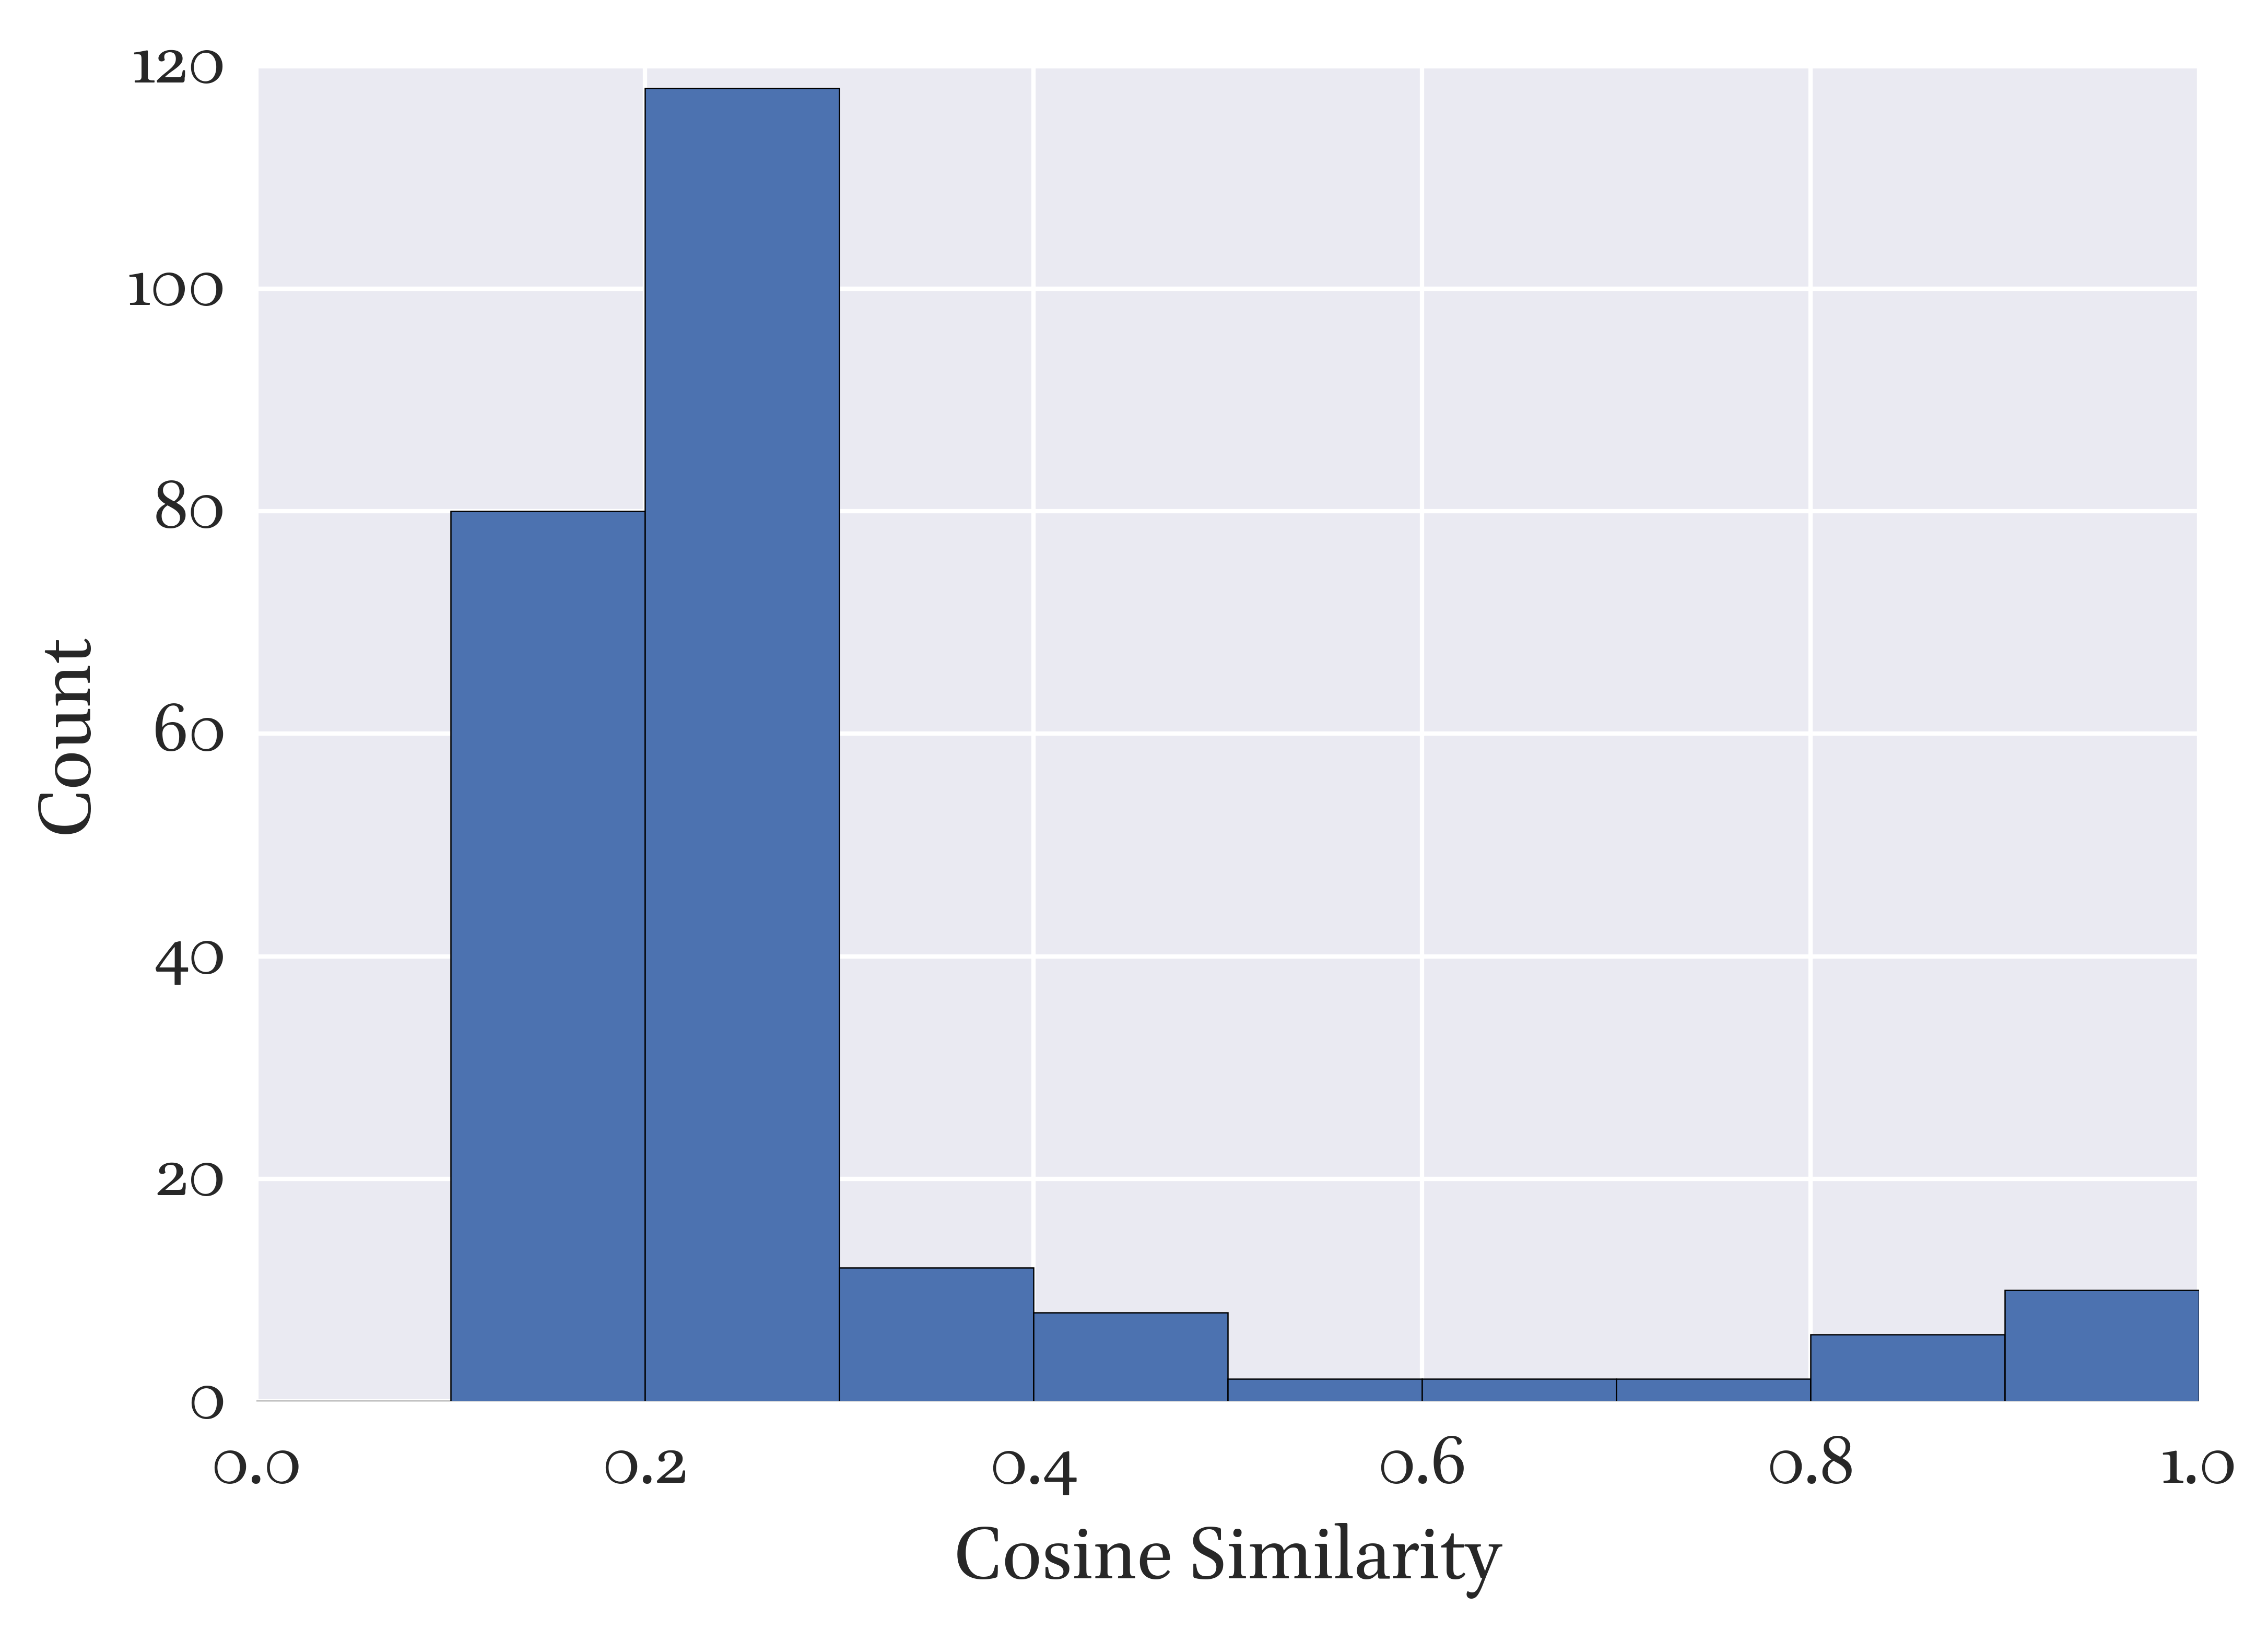

In [31]:
matrix = make_adjacency_matrix(dtm).as_matrix()
matrix = matrix.flatten()
matrix = matrix[:int(len(matrix)/2)]
matrix = matrix[matrix > 0]
plt.figure(dpi=600)
plt.hist(matrix, bins=[0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1])
plt.xlabel('Cosine Similarity')
plt.ylabel('Count')
plt.savefig('Cell Distances.png', format='png', dpi=600)
plt.show()

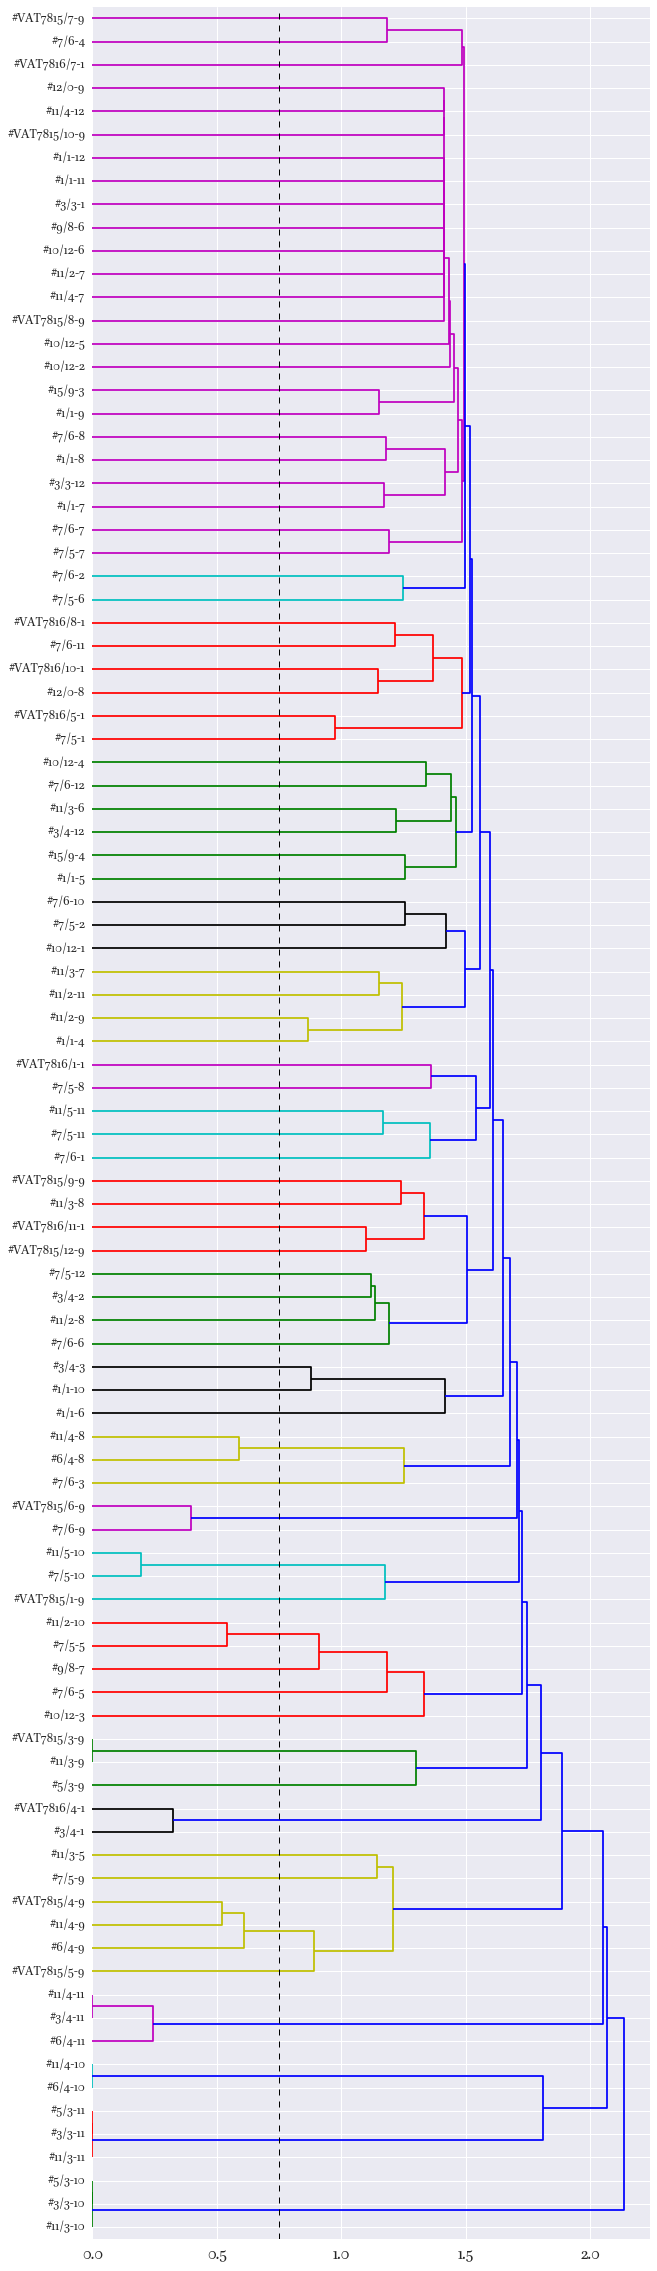

In [57]:
df_bags = make_bags(cleaned_ingredients)
dtm = make_dtm(df_bags)
matrix = make_adjacency_matrix(dtm, similarity=False)
link_matrix = average(matrix)
dendrogram(
    link_matrix, 
    orientation="right", 
    labels=df_bags[0].tolist(), 
    leaf_font_size=14,
    show_contracted=True)
fig = plt.gcf()
fig.set_size_inches(10, 40)
plt.axvline(x=.75, linewidth=1, linestyle='dashed', color='k')
plt.savefig('Cell Dendrogram.png', dpi=600, format='png')
plt.show()

In [14]:
df_bags.loc[df_bags[0].isin(['#VAT7816/5-1', '#7/5-1'])]

,0,1
33,#7/5-1,"nibru e₂.kur,eš₂₂,a.zal.la₂,an.zaḫ"
95,#VAT7816/5-1,"lam,a.zal.la₂,an.zaḫ,nibru,e₂.kur"


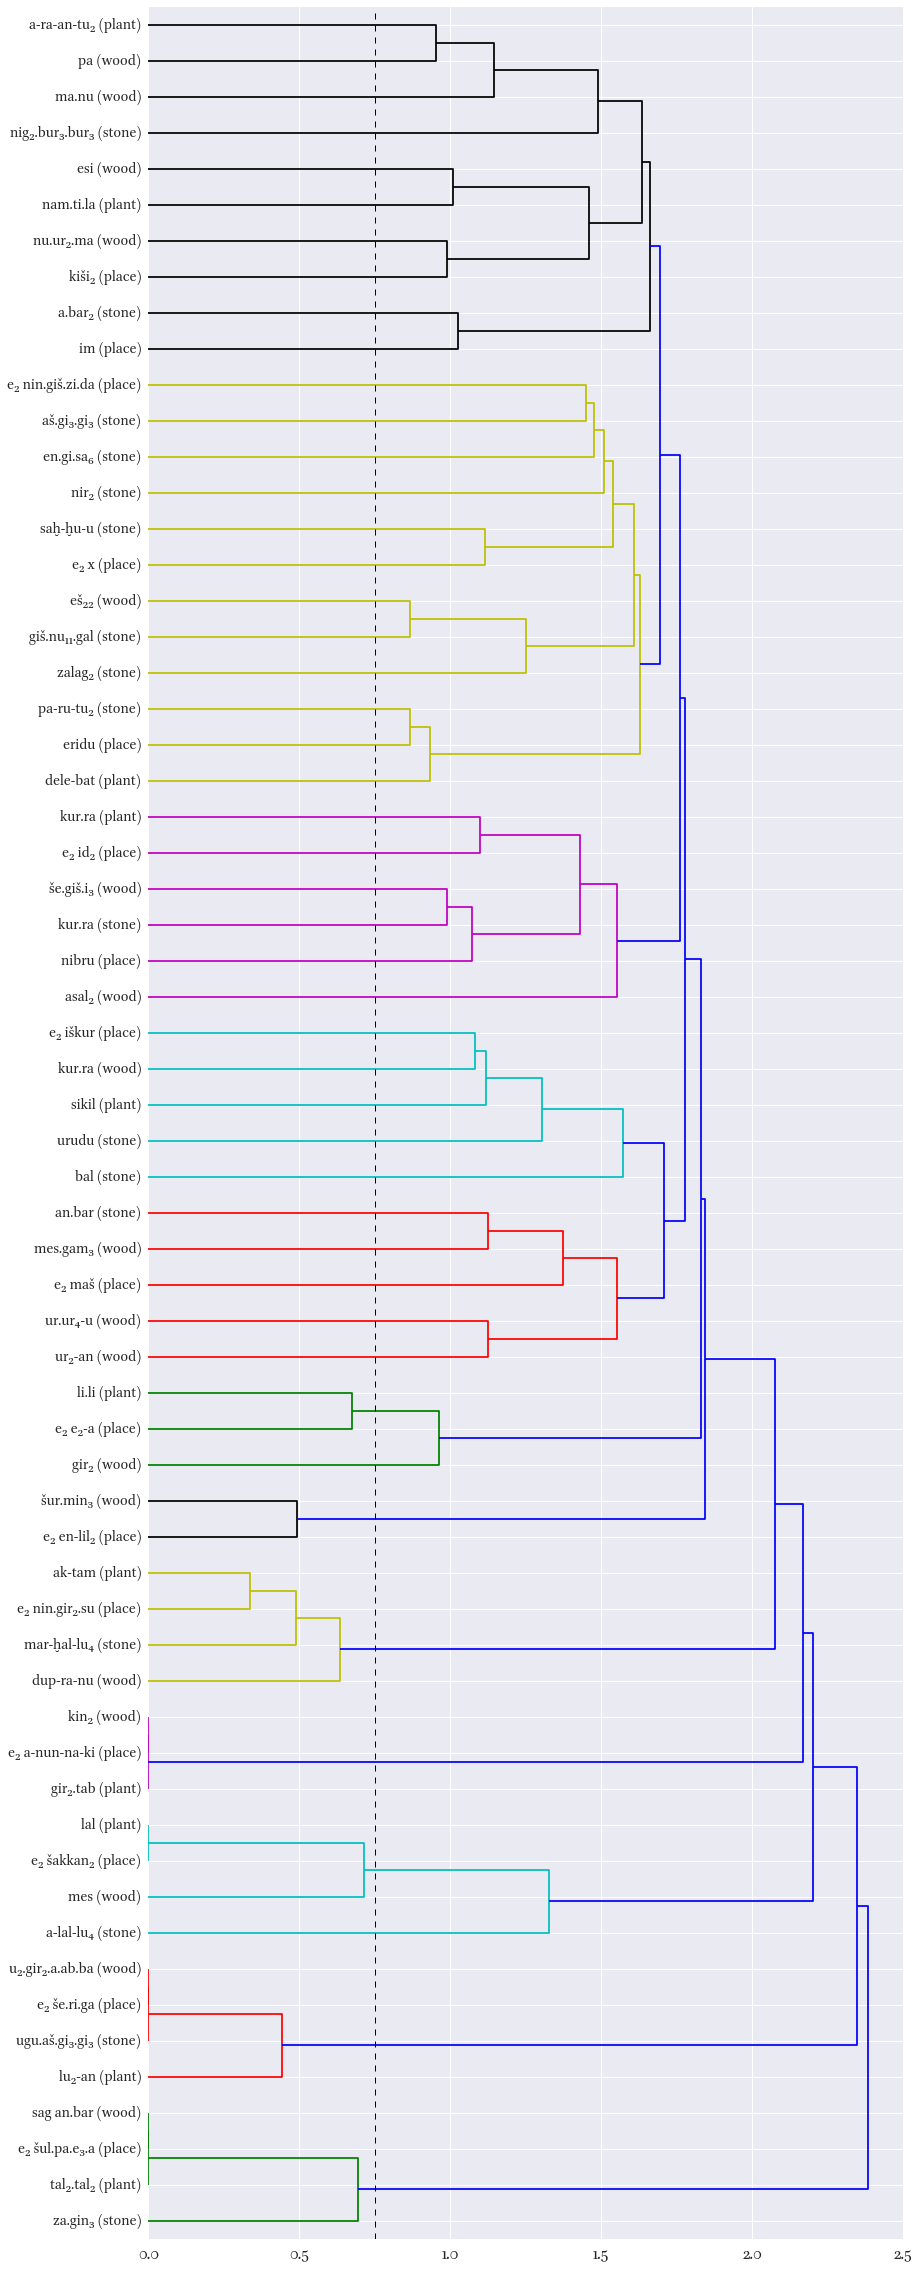

In [33]:
# Only use the Micro-zodiac material
ingredient_type_bags = make_bags(mz_ingredients, index='name_and_type', content='ID')

# Only include bags of more than 1 ingredients
ingredient_type_bags_tmp = ingredient_type_bags[ingredient_type_bags[1].str.split(',').str.len() > 1]
ingredient_type_dtm_tmp = make_dtm(ingredient_type_bags_tmp)
ingredient_type_matrix_tmp = make_adjacency_matrix(ingredient_type_dtm_tmp, similarity=False)
ingredient_link_matrix = average(ingredient_type_matrix_tmp)
dendrogram(
    ingredient_link_matrix, 
    orientation="right", 
    labels=ingredient_type_bags_tmp[0].tolist(), 
    leaf_font_size=16)
fig = plt.gcf()
fig.set_size_inches(14, 40)
# Pad the left for the long labels
fig.subplots_adjust(left=0.15)
plt.axvline(x=.75, linewidth=1, linestyle='dashed', color='k')
plt.savefig('Ingredient Dendrogram.png', dpi=600, format='png')
plt.show()

In [21]:
ingredient_type_bags_tmp.loc[ingredient_type_bags_tmp[0].isin(
    ['ugu.aš.gi₃.gi₃ (stone)', 'lu₂-an (plant)'])]

,0,1
38,lu₂-an (plant),"#3/3-10,#5/3-10,#11/3-10,#15/9-3"
39,ugu.aš.gi₃.gi₃ (stone),"#3/3-10,#5/3-10,#11/3-10"


In [22]:
df_bags.iloc[list(map(int, link_matrix[28][:2]))]

,0,1
3,#1/1-7,"ud man gar ir{ki},kur.kur,zalag₂,giš.nu₁₁.gal"
11,#3/3-12,"e₂ utu,šu₂-te₃,dele-bat,zalag₂,igi.ku₆"


In [23]:
# This gives a confidence on the reality of the clustering... 
from scipy.cluster.hierarchy import cophenet
# cophenet(linkage, pdist(X))
c, coph_dists = cophenet(
    average(make_adjacency_matrix(ingredient_type_dtm, similarity=False)),
    pdist(ingredient_type_dtm, metric='cosine'))
c

0.64831677576684288

In [24]:
# This gives a confidence on the reality of the clustering... 
from scipy.cluster.hierarchy import cophenet
# cophenet(linkage, pdist(X))
c, coph_dists = cophenet(
    average(make_adjacency_matrix(make_dtm(make_bags(cleaned_ingredients)), similarity=False)),
    pdist(make_dtm(make_bags(cleaned_ingredients)), metric='cosine'))
c

0.4141894896676736

In [ ]:
texts = ["#7/5-8", "#6/4-11","#3/4-11"]
test_bags = make_bags(cleaned_ingredients.loc[cleaned_ingredients['ID'].isin(texts)])
test_bags

In [27]:
vec = CountVectorizer(analyzer='word', token_pattern=r'[^,]+')
test_dtm = vec.fit_transform(test_bags[1])
pd.DataFrame(test_dtm.A, columns=vec.get_feature_names(), index=test_bags[0])

,ak-tam,dup-ra-nu,e₂ nin.gir₂.su,mar-ḫal-lu₄,nir₂,sig₄ unug,ši-im-ra-nu
0,,,,,,,
#3/4-11,1,1,1,1,0,0,0
#6/4-11,1,1,0,1,0,0,0
#7/5-8,0,1,0,0,1,1,1


In [34]:
matrix = cosine_similarity(test_dtm)
np.fill_diagonal(matrix, 0)
pd.DataFrame(matrix, columns=test_bags[0],  index=test_bags[0])

,#3/4-11,#6/4-11,#7/5-8
0,,,
#3/4-11,0.000000,0.866025,0.250000
#6/4-11,0.866025,0.000000,0.288675
#7/5-8,0.250000,0.288675,0.000000


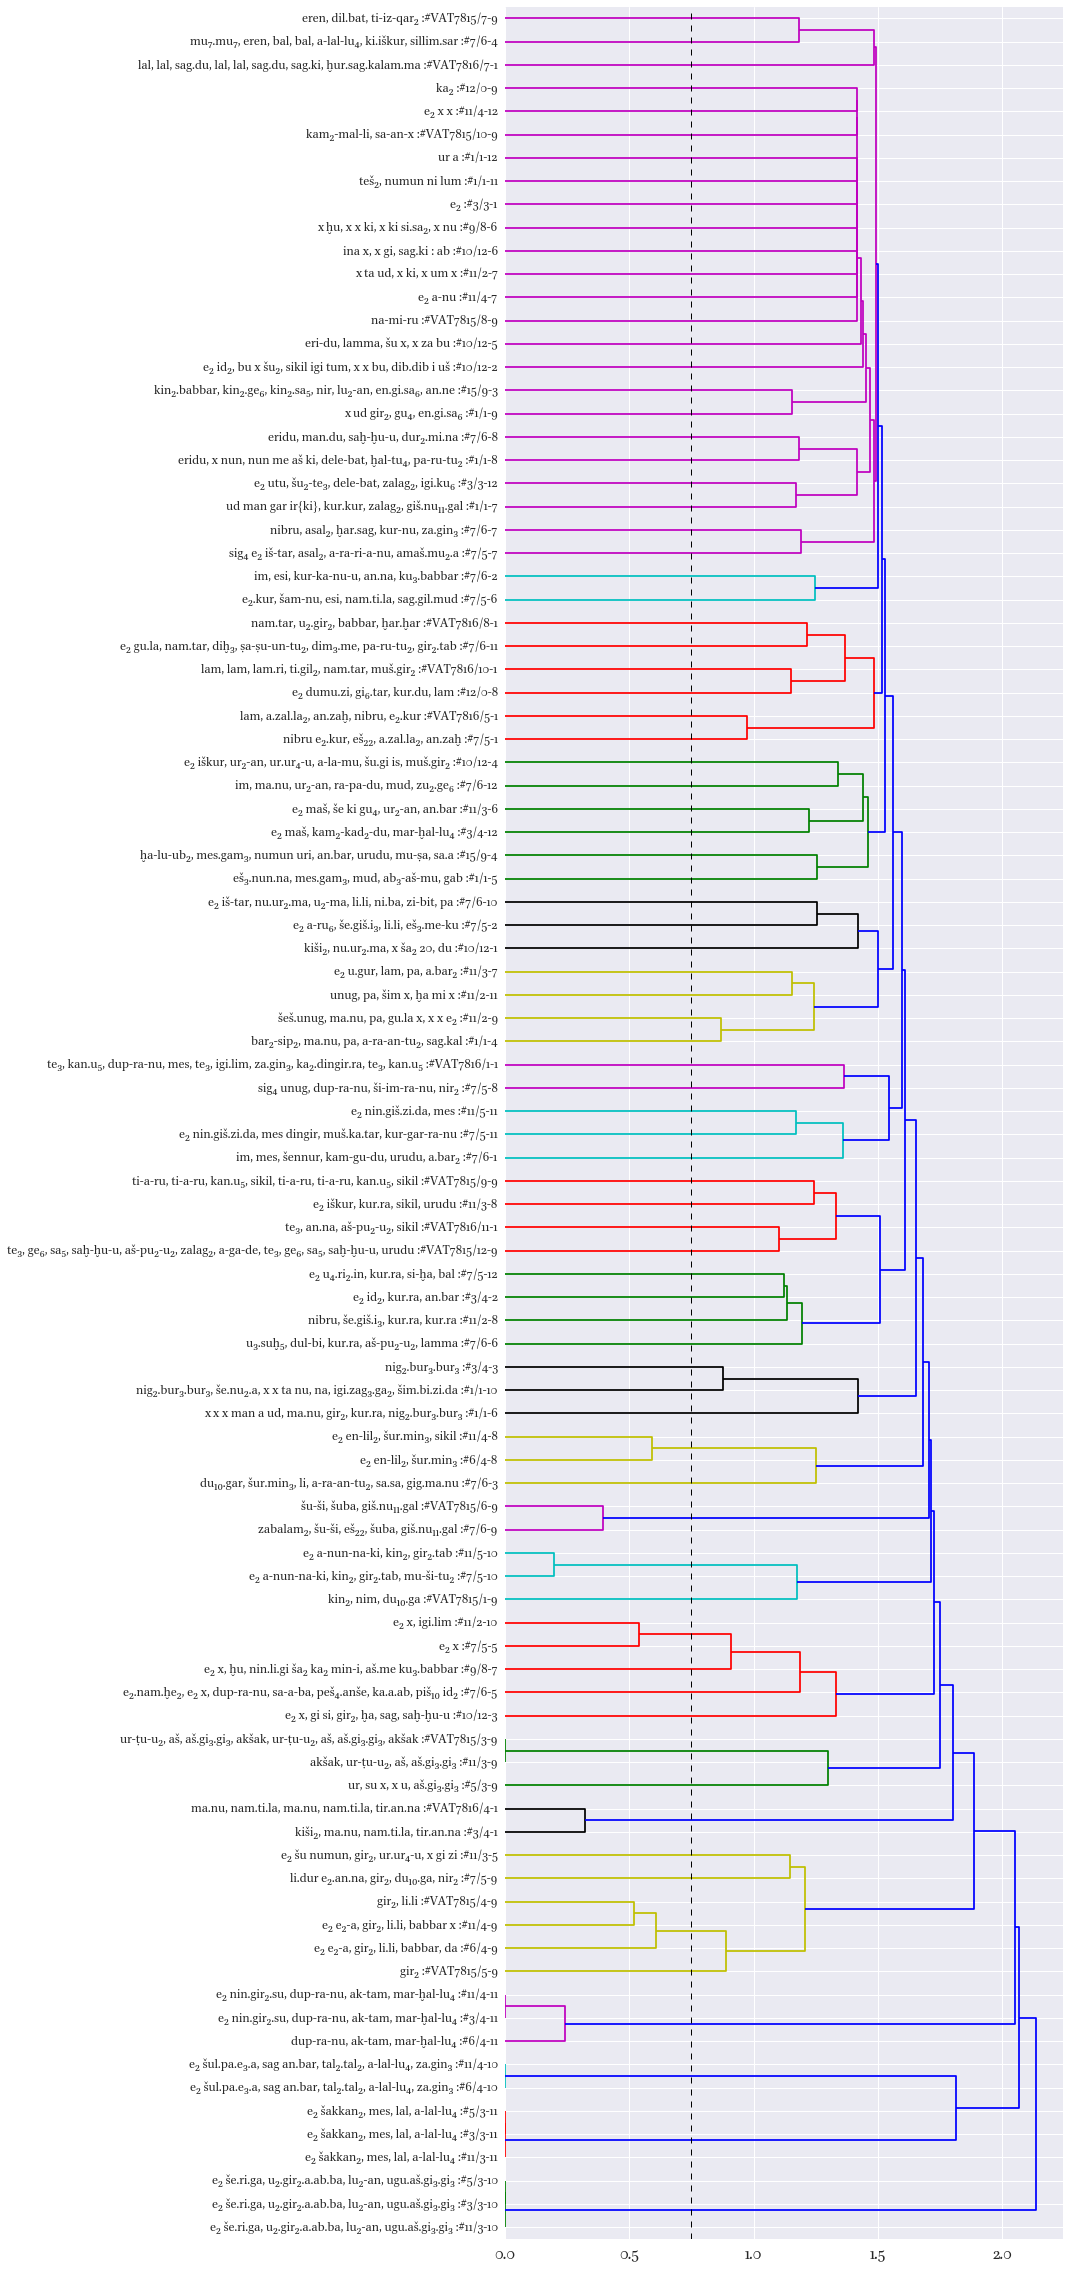

In [56]:
df_bags = make_bags(cleaned_ingredients)
dtm = make_dtm(df_bags)
matrix = make_adjacency_matrix(dtm, similarity=False)
link_matrix = average(matrix)
df_labels = [' :'.join(x) for x in zip([', '.join(x) for x in [x.split(',') for x in df_bags[1].tolist()]], df_bags[0].tolist())]
dendrogram(
    link_matrix, 
    orientation="right", 
    labels=df_labels, 
    leaf_font_size=14,
    show_contracted=True)
fig = plt.gcf()
fig.set_size_inches(10, 40)
plt.axvline(x=.75, linewidth=1, linestyle='dashed', color='k')
plt.savefig('Cell Dendrogram with full labels.png', dpi=600, format='png')
plt.show()

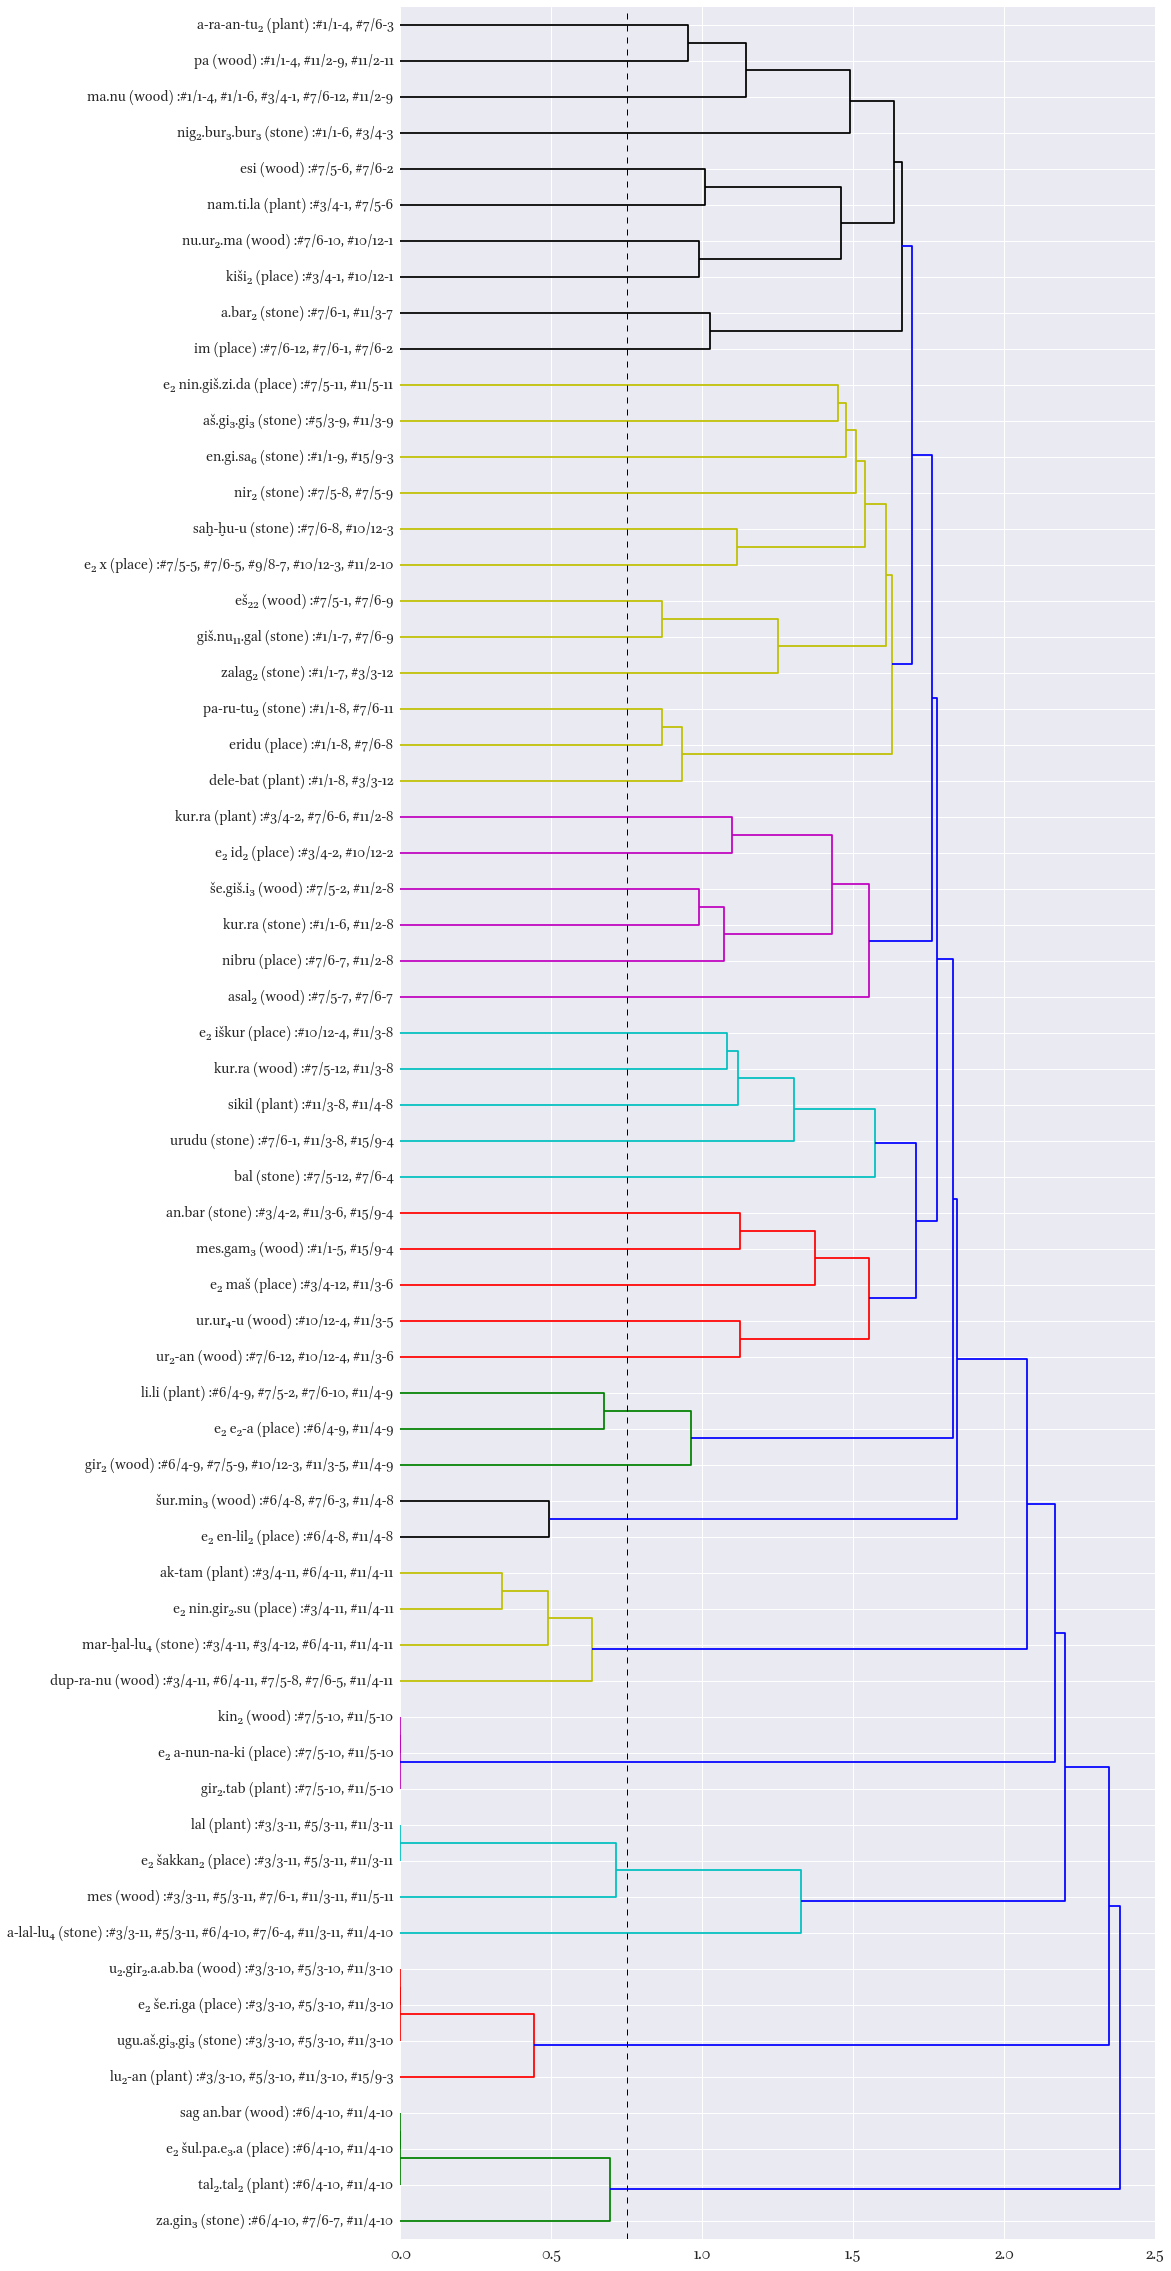

In [55]:
# Only use the Micro-zodiac material
ingredient_type_bags = make_bags(mz_ingredients, index='name_and_type', content='ID')

# Only include bags of more than 1 ingredients
ingredient_type_bags_tmp = ingredient_type_bags[ingredient_type_bags[1].str.split(',').str.len() > 1]
ingredient_type_dtm_tmp = make_dtm(ingredient_type_bags_tmp)
ingredient_type_matrix_tmp = make_adjacency_matrix(ingredient_type_dtm_tmp, similarity=False)
ingredient_link_matrix = average(ingredient_type_matrix_tmp)
df_labels = [' :'.join(x) for x in zip(
    ingredient_type_bags_tmp[0].tolist(),
    [', '.join(x) for x in [x.split(',') for x in ingredient_type_bags_tmp[1].tolist()]])]
dendrogram(
    ingredient_link_matrix, 
    orientation="right", 
    labels=df_labels, 
    leaf_font_size=16)
fig = plt.gcf()
fig.set_size_inches(14, 40)
# Pad the left for the long labels
fig.subplots_adjust(left=0.15)
plt.axvline(x=.75, linewidth=1, linestyle='dashed', color='k')
plt.savefig('Ingredient Dendrogram with full labels.png', dpi=600, format='png')
plt.show()